# ML for Insider Trading Detection in a Toy Limit Order Book

In this notebook we build an end-to-end miniature surveillance pipeline:

1. **Simulate a limit order book (LOB)** for a single asset with several agent types:
   - Noise traders
   - Market makers
   - Prop traders
   - Different kinds of illegal insiders and manipulators

2. **Generate synthetic trade data** under many market “scenarios”.

3. **Extract features** at two levels:
   - Per agent (e.g. volume, positions, P&L)
   - Per time window (e.g. volatility, volume, presence of illegal traders)

4. **Train a machine-learning model** to detect suspicious agents based on their trading behaviour.

5. **Interpret the model** and discuss what it actually learned, including some common pitfalls.

This is not a realistic surveillance system. The goal is to create a **controlled sandbox** where we can see how insider-like behaviour leaves a statistical footprint and how an ML model can pick it up.

In [1]:
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.market_simulation import (
    SimulationConfig,
    InsiderSpec,
    configure_logging,
    generate_dataset,
    run_simulation,
    sample_random_config,
)
from src.market_simulation.plotting import plot_insider_positions, plot_price_with_insider_trades

logger = configure_logging(run_id=0)

## Core limit order book structures

We start with the **order book**, the matching engine of our simulated market.

Concepts:

- **Order** – a request to buy or sell a quantity at a given price (or “at market”).
- **Order book** – two sorted lists:
  - **Bids**: buy limit orders, sorted by highest price then earliest time.
  - **Asks**: sell limit orders, sorted by lowest price then earliest time.
- **Mid-price** – the average of best bid and best ask; falls back to the fundamental value when the book is empty.

Responsibilities of the `OrderBook` class:

- Maintain the bid/ask queues.
- Insert new limit orders in **price-time priority**.
- Match incoming orders against existing ones and produce **trades**.
- Provide helper methods like best bid/ask and mid-price.

This gives us a minimal but realistic microstructure to trade in.


In [2]:
from src.market_simulation import OrderBook, Order, OrderRequest, Trade

## Agents and the common interface

Every trader in our simulation is an **agent**:

- Each agent has **cash** and **position**.
- On each time step, the agent is asked to propose **orders** (`step`).
- When a trade happens, the agent’s `on_trade` method is called to update P&L.

We also attach **labels** for later ML tasks:

- `label_is_illegal`: whether this agent is an insider/manipulator.
- `label_illegal_type`: what kind of illegal strategy it uses (event insider, pump-and-dump, etc.).
- `group_id`: used for rings of coordinated accounts.

All concrete agent types inherit from this base class and implement their own `step` behaviour.


In [3]:
from src.market_simulation.agents import Agent

### Noise traders

Noise traders model **uninformed, random flow**:

- With probability `p_trade` they place an order at each time step.
- They randomly choose **buy vs sell** (with a small optional bias).
- They randomly choose **market vs limit** orders.
- Limit orders are placed near the current mid-price with small noise.

Noise traders are important because they:

- Create background liquidity and randomness.
- Make the insiders harder to spot compared to a trivially empty market.


In [4]:
from src.market_simulation.agents import NoiseTrader

### Market makers

Market makers continuously quote both **bid** and **ask** prices:

- They cancel their previous quotes every step and post new ones.
- Quotes are centered around the current mid-price with a given **spread**.
- They manage **inventory risk** by slightly skewing quotes when they get too long/short.
- They have a `max_inventory` to avoid extreme positions.

Market makers:

- Provide tight spreads and depth in the book.
- Trade a lot but aim for **inventory neutrality** and profit from the spread.
- Serve as a useful contrast to illegal directional traders.


In [5]:
from src.market_simulation.agents import MarketMaker

### Prop traders (legal speculative traders)

Prop traders are **legal speculators** who try to exploit short-term price patterns:

- They can be **momentum** traders (buy when price is rising, sell when falling).
- Or **mean-reversion** traders (do the opposite).
- They trade with probability `p_trade` when there has been a meaningful price move.

Why add them?

- They introduce **high-activity, directional but legal** behaviour.
- This prevents the model from equating “directional trading” with “illegal” too easily.


In [6]:
from src.market_simulation.agents import PropTrader

## Illegal strategies: insiders and manipulators

All illegal strategies share some common structure:

- They are marked with `label_is_illegal = True`.
- They know whether they are part of a **group/ring** (`group_id`).
- Some of them are tied to a **fundamental event** (e.g. earnings surprise), with known:
  - `event_time`
  - `direction` (+1 for good news / price up, -1 for bad news / price down)

The `InsiderBase` class captures this shared information. Each concrete strategy only needs to implement its own `step` logic.


In [7]:
from src.market_simulation.agents import InsiderBase

### Event and slow insiders

We first define two **informational insiders** that trade around a known event:

1. `EventInsider`
   - Starts trading a bit before the event.
   - Builds a directional position (long if good news, short if bad).
   - Then unwinds over a fixed horizon after the event.

2. `SlowInsider`
   - Starts much earlier than the event.
   - Trades smaller sizes with lower intensity.
   - Mostly uses limit orders, so their behaviour looks more “patient”.

In both cases, the key idea is:
> *“Trade in the direction of the coming fundamental jump, before the rest of the market knows.”*

In [8]:
from src.market_simulation.agents import EventInsider, SlowInsider

### Stealth insiders and pump-and-dump manipulators

We then add two more sophisticated / different types of bad actors:

1. `StealthInsider`
   - Trades in the informed direction *most* of the time.
   - Occasionally places **decoy trades** in the opposite direction.
   - Uses slightly different pricing for decoys to look less suspicious.

   Idea: make the order flow look less one-sided while still building a net position.

2. `PumpAndDumpManipulator`
   - Not based on fundamental information.
   - Starts at a chosen `start_time`.
   - **Pump phase**: aggressively buy (or sell) to push the price away.
   - **Dump phase**: exit the position and (ideally) lock in profits.

In [9]:
from src.market_simulation.agents import StealthInsider, PumpAndDumpManipulator

## Simulation configuration and scenario sampler

Rather than manually specifying one market scenario, we define:

- `SimulationConfig`: describes one run of the world:
  - Length `T`
  - Whether there is a **fundamental event** (jump in true value)
  - Event time and jump size/direction
  - Numbers of noise traders, market makers, prop traders
  - A list of `InsiderSpec` entries describing illegal agents (if any)

- `InsiderSpec`: simple structure describing what kind of illegal agent to create (strategy, group id, etc.).

The helper `sample_random_config(run_id)` randomly creates a realistic-ish scenario:

- Some runs have a fundamental event, some do not.
- Events can be up or down, early or late.
- Some runs have insiders; some have none (clean markets).
- Occasionally we add pump-and-dump manipulators instead of event insiders.

By sampling many such configs we can generate a **diverse training dataset**.


In [10]:
from src.market_simulation import SimulationConfig, InsiderSpec, sample_random_config

## Simulation core: running a market scenario

`run_simulation(config)` takes a `SimulationConfig` and simulates **one world**:

1. Initialise:
   - Fundamental value (hidden true price) `v`.
   - Empty `OrderBook`.
   - All agents (market makers, prop traders, noise traders, insiders/manipulators).

2. For each time step `t`:
   - Update the **fundamental value**:
     - Random walk most of the time.
     - Optional jump at `event_time`.
   - Compute current **mid-price** from the book.
   - Ask each agent for orders via `agent.step(...)`.
   - Feed orders into the `OrderBook`, generating trades.
   - Update agents’ **cash and positions** when trades occur.
   - Record the new mid-price.

3. At the end, return:
   - The `config` (for labels).
   - Time series of `fundamental_values` and `mid_prices`.
   - The final `OrderBook`.
   - The list of all `agents`.
   - A `trades_df` DataFrame with all executed trades.

This function is the **engine** that produces synthetic market data for one scenario.


In [11]:
# run_simulation is imported above from src.market_simulation.simulation

## Inspecting a single simulation

Before jumping into machine learning, it’s useful to **see** what one simulated world looks like:

- Plot the **fundamental value** vs. **mid-price** over time.
  - We can visually inspect how prices follow the true value and react to jumps.
- Print a few **trades** to see the structure of `trades_df`.
- Build an **agent P&L summary** to see who made money and how much.

2025-12-30 17:34:36 | INFO | market_simulation | simulation_completed | run_id=0 steps=1194 trades=7993 agents=25


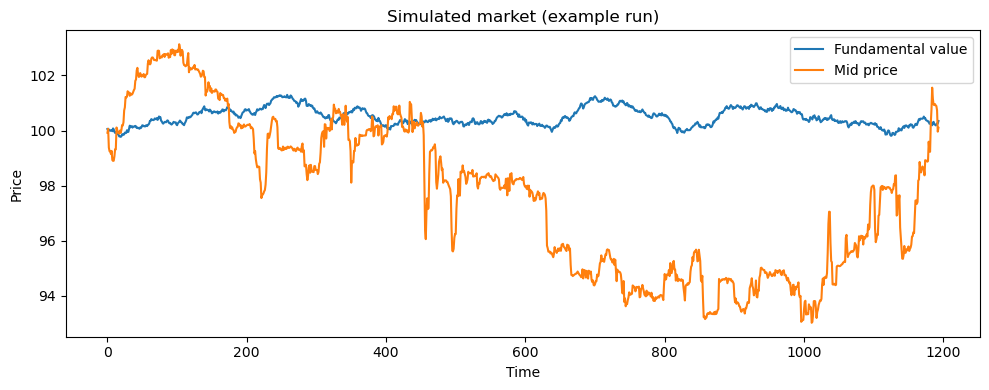

In [12]:
config_example = sample_random_config(run_id=0)
results_example = run_simulation(config_example, logger=logger)

fundamental_values = results_example.fundamental_values
mid_prices = results_example.mid_prices
event_time = config_example.event_time

plt.figure(figsize=(10, 4))
plt.plot(fundamental_values, label="Fundamental value")
plt.plot(mid_prices, label="Mid price")
if config_example.has_event and event_time is not None:
    plt.axvline(event_time, color="k", linestyle="--", label="Event time")
plt.title("Simulated market (example run)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
trades_df_example = results_example.trades_frame()
trades_df_example.head()

,time,price,quantity,buy_agent,sell_agent
0,0,99.82,11,1,8
1,0,100.30,2,12,1
2,0,100.07,2,22,14
3,0,100.07,1,23,14
4,1,99.77,8,13,1


In [14]:
last_mid = mid_prices[-1]
agents_example = results_example.agents
summary_rows = []
for a in agents_example:
    equity = a.cash + a.position * last_mid
    summary_rows.append(
        {
            "agent_id": a.id,
            "type": a.type,
            "label_is_illegal": a.label_is_illegal,
            "label_illegal_type": a.label_illegal_type,
            "group_id": a.group_id,
            "cash": round(a.cash, 2),
            "position": a.position,
            "equity": round(equity, 2),
        }
    )
summary_df_example = pd.DataFrame(summary_rows).sort_values("equity", ascending=False)
logger.info("Agent P&L summary computed. agents=%s", len(agents_example))
summary_df_example

2025-12-30 17:34:36 | INFO | market_simulation | Agent P&L summary computed. agents=25


,agent_id,type,label_is_illegal,label_illegal_type,group_id,cash,position,equity
17,18,NOISE,False,None,None,-70746.10,722,1526.10
18,19,NOISE,False,None,None,-57344.64,585,1213.86
21,22,NOISE,False,None,None,-32379.27,333,954.03
10,11,NOISE,False,None,None,-29465.84,302,764.36
6,7,NOISE,False,None,None,-9905.17,106,705.43
5,6,NOISE,False,None,None,-12793.28,131,319.82
16,17,NOISE,False,None,None,-8838.07,91,271.03
3,4,NOISE,False,None,None,7936.32,-77,228.62
22,23,NOISE,False,None,None,-5837.41,60,168.59
19,20,NOISE,False,None,None,1638.90,-15,137.40


## Feature extraction for ML

To train a detection model, we need to turn raw trades and prices into **tabular features**.

We do this at two levels:

1. **Agent-level features** (one row per agent per run):
   - Volume, number of trades, net volume, buy vs sell volume.
   - Pre-event vs post-event volume.
   - Volume aligned with the event direction (for runs with a fundamental jump).
   - Final cash, position, and equity.

2. **Window-level features** (one row per time window per run):
   - Number of trades and total volume in the window.
   - Buy vs sell volume.
   - Number of active agents.
   - Realised volatility.
   - Whether any illegal agent traded in that window.

These features are computed from the **per-trade data** using helper functions.


In [15]:
from src.market_simulation.features import (
    build_agent_trade_table,
    extract_agent_features,
    extract_window_features,
)

## Dataset generator across many scenarios

`generate_dataset` repeatedly:

1. Samples a random scenario via `sample_random_config`.
2. Runs the simulation.
3. Extracts:
   - Agent-level features for that run.
   - Window-level features for that run.

It then concatenates all runs into two big DataFrames:

- `agent_level`: each row is one agent in one run, with labels like `label_is_illegal`.
- `window_level`: each row is one time window in one run, with `has_illegal_activity`.

This is our **synthetic dataset** for training and testing ML models.

In [16]:
from src.market_simulation import generate_dataset

## Inspecting the generated dataset

Before training, we quickly check the structure of the data:

- Shapes of `agent_level` and `window_level`.
- A small sample of each to see column names and value ranges.

This sanity check is important whenever you build datasets programmatically.

In [17]:
example_data = generate_dataset(n_runs=10, window_size=50, base_seed=42, logger=logger)
agent_df_example = example_data["agent_level"]
window_df_example = example_data["window_level"]

logger.info("Agent-level dataset shape: %s", agent_df_example.shape)
logger.info("Window-level dataset shape: %s", window_df_example.shape)

2025-12-30 17:34:36 | INFO | market_simulation | dataset_generation_started | n_runs=10 window_size=50


Simulations:   0%|          | 0/10 [00:00<?, ?it/s]

2025-12-30 17:34:36 | INFO | market_simulation | simulation_completed | run_id=0 steps=1454 trades=12958 agents=36
2025-12-30 17:34:36 | INFO | market_simulation | simulation_completed | run_id=1 steps=1404 trades=10142 agents=32
2025-12-30 17:34:37 | INFO | market_simulation | simulation_completed | run_id=2 steps=806 trades=4091 agents=19
2025-12-30 17:34:37 | INFO | market_simulation | simulation_completed | run_id=3 steps=904 trades=7471 agents=31
2025-12-30 17:34:37 | INFO | market_simulation | simulation_completed | run_id=4 steps=1187 trades=9593 agents=34
2025-12-30 17:34:38 | INFO | market_simulation | simulation_completed | run_id=5 steps=1038 trades=6176 agents=25
2025-12-30 17:34:38 | INFO | market_simulation | simulation_completed | run_id=6 steps=966 trades=7772 agents=32
2025-12-30 17:34:38 | INFO | market_simulation | simulation_completed | run_id=7 steps=1273 trades=11793 agents=37
2025-12-30 17:34:39 | INFO | market_simulation | simulation_completed | run_id=8 steps=1

In [18]:
agent_df_example.head()

,run_id,agent_id,type,label_is_illegal,label_illegal_type,group_id,cash_final,position_final,equity_final,n_trades,total_volume,net_volume,avg_trade_size,buy_volume,sell_volume,pre_event_volume,post_event_volume,aligned_pre_event_volume
0,0,1,MM,False,None,NaN,-3117.83,5,-2718.505,5045,26009.0,5.0,5.155401,13007.0,13002.0,12588.0,13421.0,6294.0
1,0,2,PROP,False,None,NaN,12697.04,-157,158.235,654,2123.0,-157.0,3.246177,983.0,1140.0,1018.0,1105.0,551.0
2,0,3,PROP,False,None,NaN,-17864.67,183,-3249.375,636,2151.0,183.0,3.382075,1167.0,984.0,1123.0,1028.0,472.0
3,0,4,NOISE,False,None,NaN,18921.00,-198,3107.730,451,1896.0,-198.0,4.203991,849.0,1047.0,948.0,948.0,499.0
4,0,5,NOISE,False,None,NaN,-16282.20,174,-2385.690,533,1752.0,174.0,3.287054,963.0,789.0,1020.0,732.0,423.0


In [19]:
window_df_example.head()

,run_id,window_index,start_time,end_time,n_trades,total_volume,buy_volume,sell_volume,n_active_agents,realized_volatility,has_illegal_activity,event_distance
0,0,0,0,50,374,1598.0,1598.0,1598.0,36,0.000570,0,-692.0
1,0,1,50,100,525,2102.0,2102.0,2102.0,36,0.001288,0,-642.0
2,0,2,100,150,425,1681.0,1681.0,1681.0,36,0.002475,0,-592.0
3,0,3,150,200,488,2028.0,2028.0,2028.0,36,0.002525,0,-542.0
4,0,4,200,250,421,1701.0,1701.0,1701.0,36,0.003617,0,-492.0


## Visualizing insider behaviour

To build intuition for what the illegal agents are doing, we add two visual tools:

1. `plot_price_with_insider_trades(results)`
   - Plots mid-price and fundamental value.
   - Overlays buys and sells of **illegal agents** as markers in time and price.
   - Shows event time if there is a fundamental jump.

2. `plot_insider_positions(results)`
   - Reconstructs each illegal agent’s **position over time**.
   - Plots these position paths and marks the event time.

These visuals let students see how different insider strategies (event, slow, stealth, pump-and-dump) look in terms of actual trades and inventory paths.

In [20]:
from src.market_simulation.plotting import plot_price_with_insider_trades, plot_insider_positions

2025-12-30 17:34:40 | INFO | market_simulation | simulation_completed | run_id=1 steps=937 trades=5059 agents=18


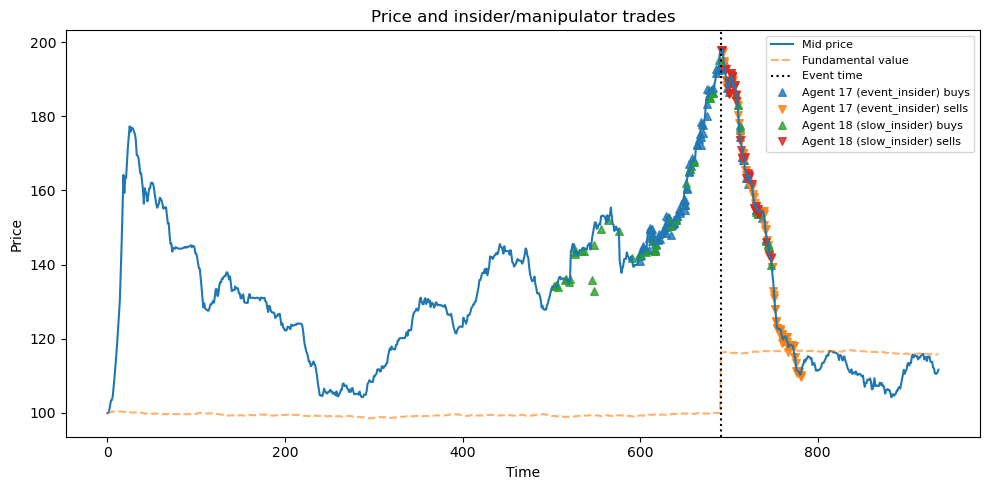

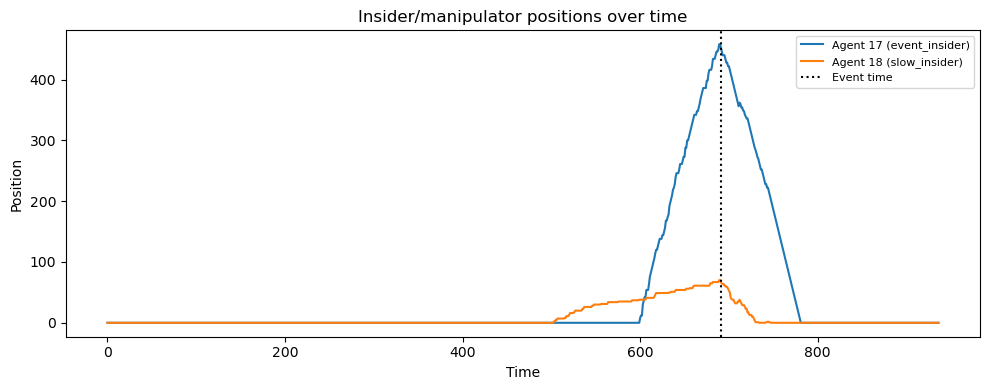

In [21]:
config_example = sample_random_config(run_id=1)
results_example = run_simulation(config_example, logger=logger)

fig1, ax1 = plot_price_with_insider_trades(results_example, logger=logger)
fig2, ax2 = plot_insider_positions(results_example, logger=logger)

## Preparing the agent-level dataset for ML

We now use our simulation machinery to build a dataset for supervised learning:

1. Generate many runs with `generate_dataset`.
2. Keep only the `agent_level` DataFrame.
3. Drop agents that never trade (`n_trades == 0`).
4. Define:
   - Label `y = label_is_illegal` (0 = legal, 1 = illegal).
   - Feature matrix `X` from behavioural numeric columns only.
5. Split by `run_id` into:
   - Training runs.
   - Test runs (completely different scenarios).

This ensures the model is tested on **new markets**, not just new agents in a known market.

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

In [23]:
ml_data = generate_dataset(n_runs=250, window_size=50, base_seed=123, logger=logger)
agent_df = ml_data["agent_level"].copy()

logger.info("Full agent-level dataset shape: %s", agent_df.shape)
label_distribution = agent_df["label_is_illegal"].value_counts(normalize=True)
label_distribution

2025-12-30 17:34:42 | INFO | market_simulation | dataset_generation_started | n_runs=250 window_size=50


Simulations:   0%|          | 0/250 [00:00<?, ?it/s]

2025-12-30 17:34:42 | INFO | market_simulation | simulation_completed | run_id=0 steps=853 trades=8117 agents=40
2025-12-30 17:34:42 | INFO | market_simulation | simulation_completed | run_id=1 steps=938 trades=3456 agents=12
2025-12-30 17:34:42 | INFO | market_simulation | simulation_completed | run_id=2 steps=871 trades=2784 agents=13
2025-12-30 17:34:43 | INFO | market_simulation | simulation_completed | run_id=3 steps=1098 trades=9281 agents=31
2025-12-30 17:34:43 | INFO | market_simulation | simulation_completed | run_id=4 steps=1112 trades=5410 agents=17
2025-12-30 17:34:43 | INFO | market_simulation | simulation_completed | run_id=5 steps=1183 trades=14745 agents=45
2025-12-30 17:34:44 | INFO | market_simulation | simulation_completed | run_id=6 steps=1267 trades=13239 agents=38
2025-12-30 17:34:44 | INFO | market_simulation | simulation_completed | run_id=7 steps=1215 trades=12422 agents=44
2025-12-30 17:34:45 | INFO | market_simulation | simulation_completed | run_id=8 steps=1

label_is_illegal
False    0.960866
True     0.039134
Name: proportion, dtype: float64

In [24]:
agent_df = agent_df[agent_df["n_trades"] > 0].reset_index(drop=True)
logger.info("After dropping agents with zero trades: %s", agent_df.shape)

2025-12-30 17:36:04 | INFO | market_simulation | After dropping agents with zero trades: (7206, 18)


In [25]:
label_col = "label_is_illegal"
y = agent_df[label_col].astype(int)

drop_cols = [
    "label_is_illegal",
    "label_illegal_type",
    "type",
    "group_id",
    "agent_id",
    "run_id",
]
feature_cols = [c for c in agent_df.columns if c not in drop_cols]
X = agent_df[feature_cols]

logger.info("Feature columns used: %s", feature_cols)

2025-12-30 17:36:04 | INFO | market_simulation | Feature columns used: ['cash_final', 'position_final', 'equity_final', 'n_trades', 'total_volume', 'net_volume', 'avg_trade_size', 'buy_volume', 'sell_volume', 'pre_event_volume', 'post_event_volume', 'aligned_pre_event_volume']


In [26]:
unique_runs = agent_df["run_id"].unique()
train_runs, test_runs = train_test_split(
    unique_runs, test_size=0.3, random_state=42
)

train_mask = agent_df["run_id"].isin(train_runs)
test_mask = agent_df["run_id"].isin(test_runs)

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

logger.info("Train set size: %s agents from %s runs", X_train.shape[0], len(train_runs))
logger.info("Test set size: %s agents from %s runs", X_test.shape[0], len(test_runs))

2025-12-30 17:36:05 | INFO | market_simulation | Train set size: 5045 agents from 175 runs
2025-12-30 17:36:05 | INFO | market_simulation | Test set size: 2161 agents from 75 runs


## Training and evaluating a Random Forest classifier

We now fit a simple model:

- Standardize features with `StandardScaler`.
- Train a `RandomForestClassifier` with:
  - `n_estimators=200`
  - `max_depth=6`
  - `class_weight='balanced'` to compensate for the rarity of illegal agents.

We then evaluate:

- Classification report (precision, recall, F1).
- Confusion matrix.
- ROC AUC (using predicted probabilities).

The goal is not to optimise hyperparameters but to show that **behavioural features carry signal** about who is likely illegal.

In [27]:
clf = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "model",
            RandomForestClassifier(
                n_estimators=200,
                max_depth=6,
                random_state=42,
                class_weight="balanced",
            ),
        ),
    ]
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

report = classification_report(y_test, y_pred, digits=3)
logger.info("Agent-level classification report (test set):\n%s", report)

2025-12-30 17:36:05 | INFO | market_simulation | Agent-level classification report (test set):
              precision    recall  f1-score   support

           0      0.993     0.976     0.985      2083
           1      0.566     0.821     0.670        78

    accuracy                          0.971      2161
   macro avg      0.780     0.898     0.827      2161
weighted avg      0.978     0.971     0.973      2161



In [28]:
cm = confusion_matrix(y_test, y_pred)
logger.info("Confusion matrix (rows=true, cols=pred):\n%s", cm)

try:
    auc = roc_auc_score(y_test, y_proba)
    logger.info("ROC AUC (test): %.3f", auc)
except ValueError:
    logger.info("ROC AUC could not be computed (only one class present in y_test).")

2025-12-30 17:36:05 | INFO | market_simulation | Confusion matrix (rows=true, cols=pred):
[[2034   49]
 [  14   64]]
2025-12-30 17:36:05 | INFO | market_simulation | ROC AUC (test): 0.985


## Which features does the model rely on?

Random Forests can report **feature importances** based on how much each feature reduces impurity across trees.

We inspect these importances to see:

- Which behavioural patterns the model finds most informative.
- Whether the model is relying mostly on a small subset of features (e.g. `n_trades`) or a broader mix (volume, positions, event-aligned volume, etc.).

In [29]:
rf_model = clf.named_steps["model"]
importances = rf_model.feature_importances_
feat_imp = (
    pd.DataFrame({"feature": feature_cols, "importance": importances})
    .sort_values("importance", ascending=False)
)

logger.info("Top 10 most important features:\n%s", feat_imp.head(10))
feat_imp.head(10)

2025-12-30 17:36:05 | INFO | market_simulation | Top 10 most important features:
                     feature  importance
3                   n_trades    0.211067
1             position_final    0.146021
5                 net_volume    0.128801
9           pre_event_volume    0.111504
8                sell_volume    0.080301
4               total_volume    0.072810
7                 buy_volume    0.066751
11  aligned_pre_event_volume    0.052829
6             avg_trade_size    0.045055
0                 cash_final    0.039367


,feature,importance
3,n_trades,0.211067
1,position_final,0.146021
5,net_volume,0.128801
9,pre_event_volume,0.111504
8,sell_volume,0.080301
4,total_volume,0.072810
7,buy_volume,0.066751
11,aligned_pre_event_volume,0.052829
6,avg_trade_size,0.045055
0,cash_final,0.039367


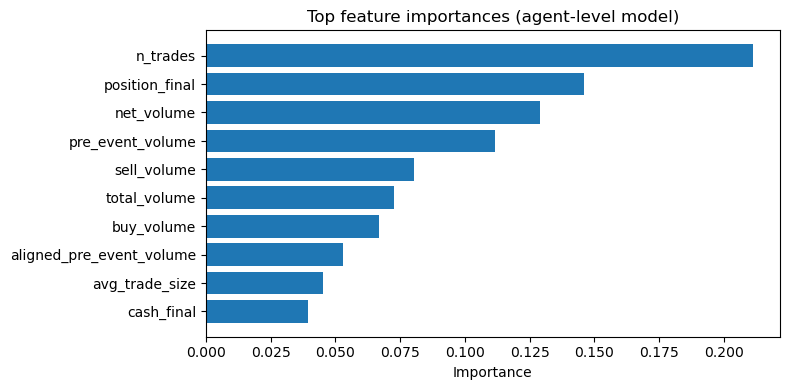

In [30]:
plt.figure(figsize=(8, 4))
top_n = 10
plt.barh(
    feat_imp["feature"].head(top_n)[::-1],
    feat_imp["importance"].head(top_n)[::-1],
)
plt.title("Top feature importances (agent-level model)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## Interpreting the model: how important is `n_trades`?

The feature importance plot shows `n_trades` as the most important feature.
To understand this, we:

1. Examine the **distribution of `n_trades` by label**:
   - Compute summary statistics separately for legal and illegal agents.
   - Plot a boxplot of `n_trades` vs `label_is_illegal`.

2. Retrain the model **without** `n_trades`:
   - Compare classification report and ROC AUC to the original model.
   - See whether performance drops significantly or only slightly.

This is a great teaching moment:

- A highly important feature might be used mainly as a **“rule-out” signal** (“extremely active looks like a market maker, not an insider”).
- Removing it shows whether the model actually relies on richer behavioural patterns like net volume and event-aligned volume.

In [31]:
agent_df.groupby("label_is_illegal")["n_trades"].describe()

,count,mean,std,min,25%,50%,75%,max
label_is_illegal,,,,,,,,
False,6924.0,596.339399,814.515441,89.0,286.0,411.0,565.0,7552.0
True,282.0,181.361702,83.165511,44.0,111.0,168.0,242.5,419.0


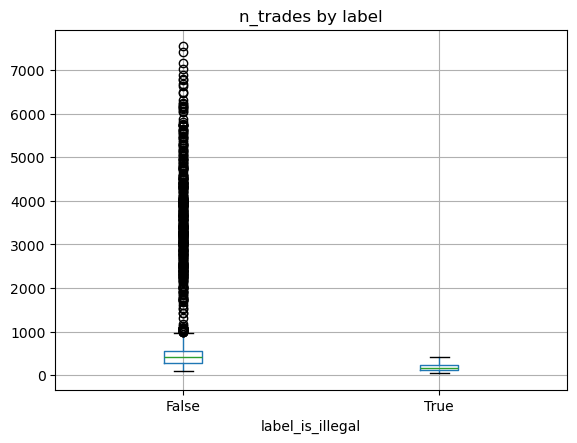

In [32]:
agent_df.boxplot(column="n_trades", by="label_is_illegal")
plt.suptitle("")
plt.title("n_trades by label")
plt.show()

In [33]:
X_no_n = agent_df[[c for c in feature_cols if c != "n_trades"]]

X_train_no_n, X_test_no_n = X_no_n[train_mask], X_no_n[test_mask]

clf_no_n = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("model", RandomForestClassifier(
            n_estimators=200,
            max_depth=6,
            random_state=42,
            class_weight="balanced",
        )),
    ]
)

clf_no_n.fit(X_train_no_n, y_train)
y_pred_no_n = clf_no_n.predict(X_test_no_n)
y_proba_no_n = clf_no_n.predict_proba(X_test_no_n)[:, 1]

report_no_n = classification_report(y_test, y_pred_no_n, digits=3)
logger.info("Classification report (no n_trades):\n%s", report_no_n)
logger.info("ROC AUC (no n_trades): %.3f", roc_auc_score(y_test, y_proba_no_n))

2025-12-30 17:36:07 | INFO | market_simulation | Classification report (no n_trades):
              precision    recall  f1-score   support

           0      0.992     0.979     0.985      2083
           1      0.581     0.782     0.667        78

    accuracy                          0.972      2161
   macro avg      0.786     0.880     0.826      2161
weighted avg      0.977     0.972     0.974      2161

2025-12-30 17:36:07 | INFO | market_simulation | ROC AUC (no n_trades): 0.984
